<table style="width:100%"><tr>
<td> 
    
Technische Universität Berlin\
Electrical Engineering and Computer Science\
Internet of Things for Smart Buildings\
Prof. Dr. Sergio Lucia, Felix Fiedler, Benjamin Karg </td>
<td>  <img src="logo_tu.png" style="width: 20%;" align="right"/> </td>
</tr>
</table>

***
**MPC 20 - Exercise 03**
***

# <span class="graffiti-highlight graffiti-id_2hkv6mq-id_kth1xog"><i></i>Please click here!</span>

# MPC implementation with CasADi

In this exercise we will continue working with the Python library [CasADi](https://web.casadi.org/docs/)
and use it to implement our own MPC. 
**We assume that you have completed the previous exercise in which we showed you the basics of CasADi.**
If you are working locally (on your computer) you need to have CasADi installed.


Import the required Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import *

We also change some Matplotlib parameters to increase the font size. Here is some [information](https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html) on how this works.

In [2]:
mpl.rcParams['font.size'] = 16

### Define a linear system as a CasADi function

In the following we investigate a simple linear system consissting of two linear oscillating masses which are connected through springs and can be controlled with a single input.
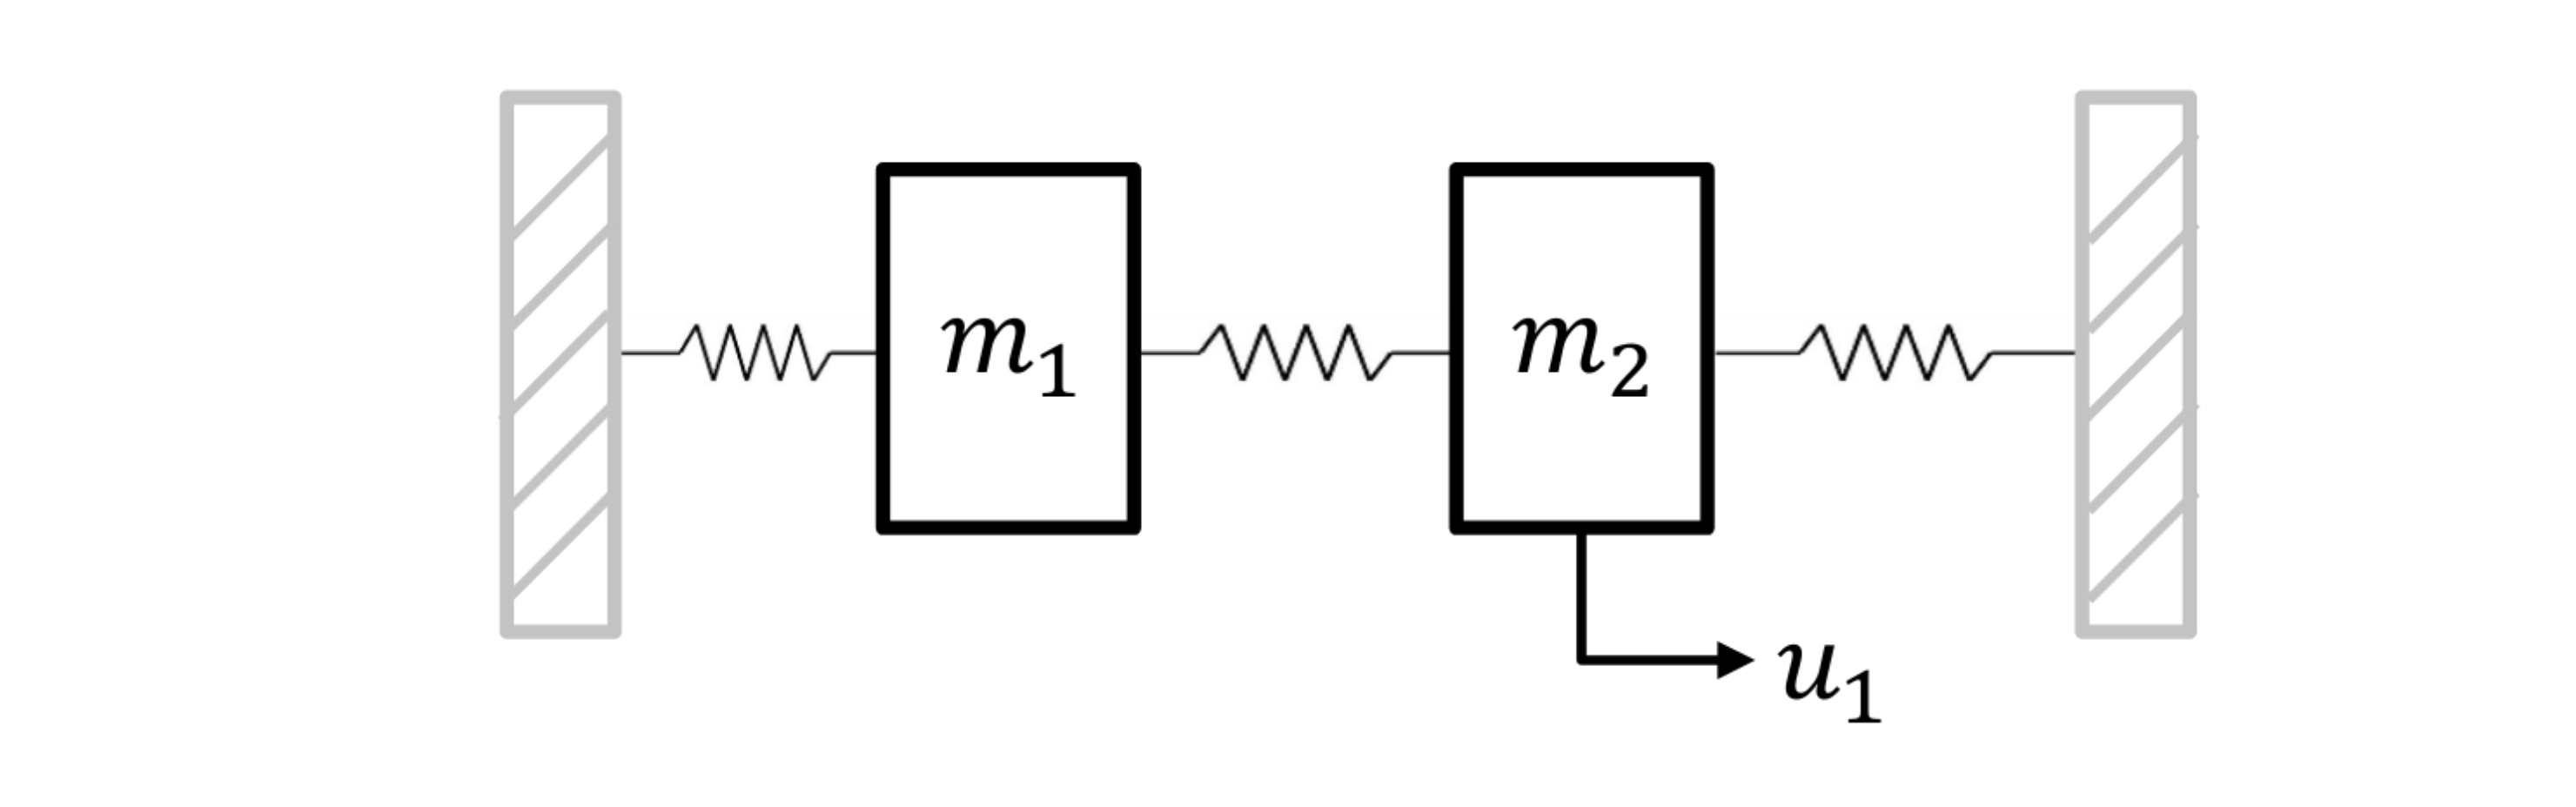

We define that linear system in discrete-time state-space form such that:

$$ x_{k+1} = Ax_{k}+Bu_{k}$$

where $x\in \mathbb{R}^n$, are the states of the system
and $u \in \mathbb{R}^m$ are the inputs.
The subscript $k$ and $k+1$ respectively, denote the discrete time instance of these variables.
In our case, the states are the displacement of the masses from their resting position as well as their velocity.


The state space system is defined in terms of the **system matrix** $A\in \mathbb{R}^{n\times n}$ and the **input matrix** $B\in \mathbb{R^{n\times m}}$. We skip the derivation and parameters of the system and just give you the numerical values of the resulting matrices.

In [3]:
# System matrix:
A = np.array([[ 0.76272095,  0.45961393,  0.11486161,  0.0198116 ],
               [-0.89941626,  0.76272095,  0.41999073,  0.11486161],
               [ 0.11486161,  0.0198116 ,  0.76272095,  0.45961393],
               [ 0.41999073,  0.11486161, -0.89941626,  0.76272095]])
nx = A.shape[1]
print(A)
print('A.shape = {}'.format(A.shape))

[[ 0.76272095  0.45961393  0.11486161  0.0198116 ]
 [-0.89941626  0.76272095  0.41999073  0.11486161]
 [ 0.11486161  0.0198116   0.76272095  0.45961393]
 [ 0.41999073  0.11486161 -0.89941626  0.76272095]]
A.shape = (4, 4)


In [4]:
# The input matrix is defined as
B = np.array([[0.01413191],
            [0.06277108],
            [0.22062828],
            [0.36695456]])

nu = B.shape[1]
print(B)
print('B.shape = {}'.format(B.shape))

[[0.01413191]
 [0.06277108]
 [0.22062828]
 [0.36695456]]
B.shape = (4, 1)


## Task 01: Investigate the stability of the proposed system

In a small preliminary task we investigate the stability property of the presented system.
For this purpose, we ask you to:

1. Determine the Eigenvalues of the system matrix. <br>
**On a sidenote**: You can trigger the help / doc string of any function simply by writing:
```
np.linalg.eig?
```
2. What is the stability region of time-discrete state-space systems?
3. Plot or compare the eigenvalues with the stability criteria.

(-1, 1)

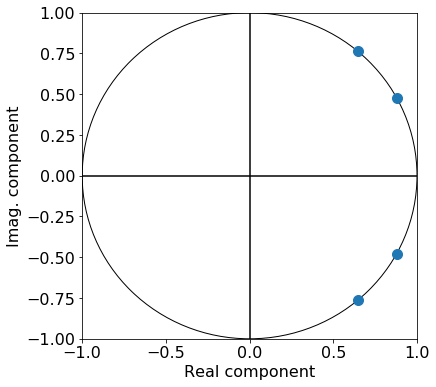

In [5]:
# Check the eigenvalues of the uncontrolled system (u = 0).
# You can check available methods by pressing TAB after "."
lam, v = np.linalg.eig(A)
# Note that you obtain here the eigenvalues and the eigenvectors

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Real component')
ax.set_ylabel('Imag. component')
ax.add_artist(plt.Circle((0, 0), 1,edgecolor='k', fill=False))
ax.plot(np.real(lam),np.imag(lam),'o', markersize=10)
ax.axhline(0,color='k')
ax.axvline(0,color='k')
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)

The stability region of a discrete-time system is **within the unit circle**. As the eigenvalues lay directly on this circle, we can conclude that the system is stable but **not** asymptotically stable. 

## Task 02: Create a symbolic expression of the state-space system

We can also evalute the state-space system symbolically:
1. Create symbolic variables x and u with their respective dimension. Note that we already created the variables nx and nu above.

In [6]:
# Define state and input as CasADi symbols
x = SX.sym("x",nx,1)
u = SX.sym("u",nu,1)

2. Create an symbolic expression for $x_{k+1}$ and a Function that takes two inputs ($x_k$, $u_k$) and returns $x_{k+1}$. This function should be named **system**:
```python
system = Function(...)
```

You may need to have a look at this list of [CasADi operations.](https://web.casadi.org/docs/#list-of-operations). An even more complete list can be found [here](https://web.casadi.org/python-api/). Note also that some numpy operations, such as np.sin work. 


In [7]:
# Define the dynamics as a CasADi expression
x_next = A@x + B@u 

# Create the CasADi function
f = Function("sys",[x,u],[x_next])

print(x_next)

@1=0.762721, @2=0.459614, @3=0.114862, @4=0.0198116, @5=-0.899416, @6=0.419991, [(((((@1*x_0)+(@2*x_1))+(@3*x_2))+(@4*x_3))+(0.0141319*u)), (((((@5*x_0)+(@1*x_1))+(@6*x_2))+(@3*x_3))+(0.0627711*u)), (((((@3*x_0)+(@4*x_1))+(@1*x_2))+(@2*x_3))+(0.220628*u)), (((((@6*x_0)+(@3*x_1))+(@5*x_2))+(@1*x_3))+(0.366955*u))]


3. Run the following code and see if it returns:
```
DM([1.37114, 0.460928, 1.57764, 0.765112])
```




In [8]:
x0 = np.ones((4,1))
u0 = np.ones((1,1))
f(x0,u0)

DM([1.37114, 0.460928, 1.57764, 0.765112])

**Just a small hint** for the implementation shown later (maybe this will not mean a anything to you just yet): You can also call functions with symbolic variables, e.g.:

In [9]:
a = SX.sym("a", nx, 1)
b = SX.sym("b", nu, 1)

a_next = f(a,b)

print(a_next)

@1=0.762721, @2=0.459614, @3=0.114862, @4=0.0198116, @5=-0.899416, @6=0.419991, [(((((@1*a_0)+(@2*a_1))+(@3*a_2))+(@4*a_3))+(0.0141319*b)), (((((@5*a_0)+(@1*a_1))+(@6*a_2))+(@3*a_3))+(0.0627711*b)), (((((@3*a_0)+(@4*a_1))+(@1*a_2))+(@2*a_3))+(0.220628*b)), (((((@6*a_0)+(@3*a_1))+(@5*a_2))+(@1*a_3))+(0.366955*b))]


We have thus obtained the same expression as defined above but in terms of a new set of variables.

## Task 03: Simulate a linear discrete-time system
We first define the initial condition ``x_0`` and the control input ``u_k`` (constant for all times). 
We also initiate a new list to store the solution of the simulation, where the first element is ``x_0``.

The system will be simulated for ``N_sim=50`` steps.

In [11]:
# Define the total steps to simulate
N_sim = 50
# Define the initial condition
x_0 = np.array([-2,2,1,-1]).reshape(4,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

res_x = [x_0]

2. Loop over ``i=0...N_sim`` and evaluate the update equation at each step.
3. Reset the initial state 
4. Save the current state by appending it to ``res_x``

5. After the loop has finished, concatenate the arrays in the list ``res_x``, such that you obtain an array of shape ``(nx, N_sim)``

In [12]:
# Loop over i until N_sim to simulate
for i in range(N_sim):
    x_next = f(x_0,u_k)
    res_x.append(x_next)
    x_0 = x_next

# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)

In [13]:
res_x.shape

(4, 51)

This should yield ``(4,51)``

## Plotting the results
We have prepared this code to plot your simulation results:

Text(0.5, 0, 'time')

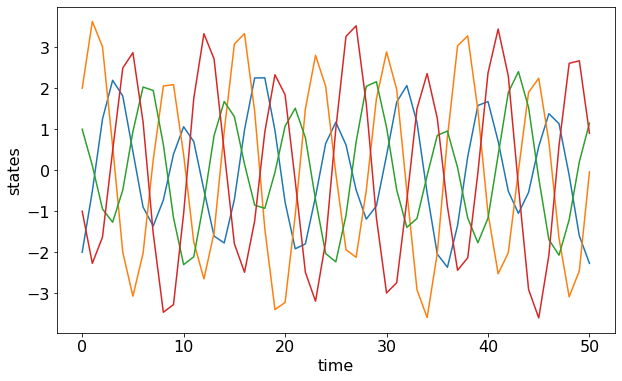

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
ax.plot(res_x.T)
ax.set_ylabel('states')

ax.set_xlabel('time')


As expected, the system is stable but not asymptotically stable.

# MPC Tutorial

In this section we will formulate and run the MPC problem to regulate the system that was introduced above. Regulation means that the states are brought to zero. To achieve this goal we use a very common quadratic cost function, where for every time step $k$ of the horizon the following expression should be minimized:

$$l(x_k,u_k) = x_k^T Q x_k + u_k^T R u_k $$

where Q and R are positive definite diagonal matrices. 
For the terminal cost we have a slightly altered expression:

$$ m(x_{N+1}) = x_{N+1}^T Q x_{N+1}, $$ 

since $u_{N+1}$ does not exist.

Implementing and running the MPC controller for the previously introduced system and with the shown cost function can be roughly split into three steps. These steps are shown in the following.

## 1. Configuration for a generic stage 

The MPC optimization problem can be seen as having multiple stages corresponding to the time-steps of the prediction horizon. Stages are interconnected through the dynamic state equation and individually contribute to the MPC cost function. 
We advice to start the MPC implementation by configuring all components for a generic stage.
These components are 

- dynamic state equation
- the stage cost function (terminal cost function for the last state of the sequence)
- constraints for stage variables (upper and lower bounds in this example)

As you will see later, it is convenient to obtain CasADi functions for the first and second component. 
Since we have already created the **dynamic state equation in CasADi** above, it remains to obtain the **state and terminal cost functions** and to define the **upper and lower bounds for the optimization variables**.

<img src="01_implementation_scheme.svg" style="width: 90%;" align="center"/>

## Choose the tuning of MPC
Above we have formulated the cost function with arbitrary (positve definite) matrices. For the implementation you need to choose numerical values which will effect your controller performance. We provide here some values that yield a working controller but **you are invited to play with these values, once the algorithm is running.**

In [14]:
Q = 20
Q = Q*np.diag(np.ones(nx))
print(Q)

[[20.  0.  0.  0.]
 [ 0. 20.  0.  0.]
 [ 0.  0. 20.  0.]
 [ 0.  0.  0. 20.]]


In [15]:
R = 10
R = np.diag(R*np.ones(nu))
print(R)

[[10.]]


Another important parameter to choose is the prediction horizon. This determines "how far we look into the future". Note that an optimal solution does not guarante stability. **Feel free to test other values for the horizon**.

In [16]:
N = 15

### Construct CasADi objective function
We now construct the cost function for the generic stage variables `x` and `u` and create CasADi functions from the resulting expressions:

In [17]:
# state cost (function of x_k and u_k)
l_exp = x.T@Q@x+ u.T@R@u
l_fcn = Function('l',[x,u],[l_exp])

# terminal cost (function of x_N)
m_exp = x.T@Q@x
m_fcn = Function('m',[x],[m_exp])

### Upper and lower bounds for stage variables:

In [18]:
# state constraints
lb_x = -4*np.ones((nx,1))
ub_x = 4*np.ones((nx,1))
# input constraints
lb_u = -1.5*np.ones((nu,1))
ub_u = 1.5*np.ones((nu,1))

## 2. Create the optimization problem

The second step of the process is already to create the optimization problem. Note that we want to end up with something like this:

$$
\min_{x} \quad J(x)\\
\text{s.t.} \quad g_{lb}\leq g(x)\leq g_{ub}\\
\quad \ x_{lb}\leq x \leq x_{ub}
$$

We thus need to create the cost function $J(x)$ and the constraint functions $g(x)$. But first of all, **we need to create our optimization variables**. These are not the previously introduced

```python
x = SX.sym("x",nx,1)
u = SX.sym("u",nu,1)
```

because we are optimizing over **sequences of states and inputs**.

<img src="02_implementation_scheme.svg" style="width: 90%;" align="center"/>

## Define optimization variables

Note that the upper cases variables **X** and **U** are stacked vectors that contain the states and inputs for all time-steps. Also note that **X** contains one additional sequence element than **U**.

In [19]:
X = SX.sym("X",(N+1)*nx,1)
U = SX.sym("U",N*nu,1)

## Task 04: Formulate MPC optimization problem
We now have everything at hand to formulate the MPC optimization problem, which consists of the cost $J$, the constraints $g$ and the bounds. We start by initializing these variables:

In [20]:
J = 0
lb_X = [] # lower bound for X.
ub_X = [] # upper bound for X
lb_U = [] # lower bound for U
ub_U = [] # upper bound for U
g = []    # constraint expression g
lbg = []  # lower bound for constraint expression g
ubg = []  # upper bound for constraint expression g

**The idea is now the following**. We are looping over the different stages of our prediction horizon:

```python
for k in range(N):
    ...
```

and at each iteration we append the stage:
- cost
- constraints
- bounds

in terms of the stage variables ``x_k`` and ``u_k``. 
Fortunately, we have already defined the functions:

- ``l(x_k,u_k)`` (stage cost)
- ``f(x_k,u_k)`` (dynamic state equation)
- ``m(x_N+1)`` (terminal cost)

which now come very handy! 
**Note that we use the dynamic state equation to include the following constraint at each stage**:

```
g_k = f(x_k, u_k) - x_{k+1}
```

Since the stage variables ``x_k`` and ``u_k`` are part of the stacked vectors ``X`` and ``U``,
we first have to retrieve them by slicing.

The full loop to create the optimization problem must thus look something like this:

```python
for k in range(N):
    x_k = X[]
    u_k = U[]
    
    ...
    
    # Cost
    J += stage_cost
    
    # constraints
    g.append(stage_constraint)
    
    # bounds
    lb_X.append(lb_x)
    ...
```

With this idea in mind, complement the following code.
We have numbered sections corresponding to their respective sub tasks as shown below:

```
# 01 - Your code here!
x = 
...
# 01
```

### Your tasks:
1. Use indexation to query the right elements of ``X`` and ``U`` for the following values:
  - ``x_k``
  - ``x_k_next``
  - ``u_k``
2. Add the cost of the current stage to the stage cost.
3. Evaluate the system equation **symbolically** to determine ``x_k_next_calc``.
4. Add the equality constraint that ``x_k_next = x_k_next_calc``. Append the expression to ``g`` and update ``lb_g``, ``ub_g`` accordingly.
5. Append the upper and lower bounds for ``x_k`` and ``u_k`` to ``lb_X``, ``ub_X``.

In [21]:
# formulate optimization problem

for k in range(N):
    # 01 - Your code here!
    x_k = X[k*nx:(k+1)*nx,:]
    x_k_next = X[(k+1)*nx:(k+2)*nx,:]
    u_k = U[k*nu:(k+1)*nu,:]
    # 01

    # 02 - Your code here!
    # objective
    J += l_fcn(x_k,u_k)
    # 02
    
    # 03 - Your code here!
    # equality constraints (system equation)
    x_k_next_calc = f(x_k,u_k)
    # 03

    # 04 - Your code here!
    g.append(x_k_next - x_k_next_calc)
    lbg.append(np.zeros((nx,1)))
    ubg.append(np.zeros((nx,1)))
    # 04

    # 05 - Your code here!
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    lb_U.append(lb_u)
    ub_U.append(ub_u)
    # 05


6. Finally, you need to include the constraints and terminal cost for the last state of the sequence. 
Since we stop at this stage there is no need to consider the dynamic state equation again.

In [22]:
# Your code here!
x_terminal = X[N*nx:(N+1)*nx,:]
J += m_fcn(x_terminal)
lb_X.append(lb_x)
ub_X.append(ub_x)

## Task 05: Create the CasADi solver for the optimization problem
To solve the problem defined above, we first need to create a CasADi ``nlpsol`` object, where an optimization problem is defined as shown here:

$$
\min_{x} \quad J(x)\\
\text{s.t.} \quad g_{lb}\leq g(x)\leq g_{ub}\\
\quad \ x_{lb}\leq x \leq x_{ub}
$$

Note that CasADi expects a single vector ``x`` as the optimization variables with corresponding upper and lower bound. 
You should thus:

- concatenate ``X`` and ``U`` to a single optimization variable.
- concatenate the bounds 
- Create the CasADi ``nlpsol`` object as described [here](https://web.casadi.org/docs/#nonlinear-programming).

**Note**: You will need the CasADi ``vertcat`` function which takes an arbitrary number of inputs. You can use the **splat** operator (*) to pass multiple inputs to a function which originate from a list, e.g.:

```python
vertcat(a,b,c,d)
# or 
vertcat(*[a,b,c,d])
# or 
vertcat(*[a,b],*[c,d])
```
whereas:
```python
vertcat([a,b,c,d])
```
will throw an error.

In [23]:
# Your code here!
lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,U)
g = vertcat(*g)
lbg = vertcat(*lbg)
ubg = vertcat(*ubg)

prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

# 3. MPC loop

Now that we have the configured solver, we can see how the MPC controller performs in action. For this we run it in the loop shown below:

<img src="03_implementation_scheme.svg" style="width: 90%;" align="center"/>

At each iteration we have to call the solver which has the following inputs:

In [24]:
print(solver)

solver:(x0[79],p[],lbx[79],ubx[79],lbg[60],ubg[60],lam_x0[79],lam_g0[60])->(x[79],f,g[60],lam_x[79],lam_g[60],lam_p[]) IpoptInterface


- **x0:** This is not the state but the initial guess for the optimization variables (``X`` and ``U``). The initial guess is optional but in many cases crucial for the success of the solver.
- **lbx:** Lower bounds to both states and control inputs. These are defined already.
- **ubx:** Upper bounds to both states and control inputs. These are defined already.
- **lbg:** Lower bounds for expression ``g``. As ``g`` contains only equality constraints, both upper and lower bounds are set to the same value.
- **ubg:** Upper bounds for expression ``g``. As ``g`` contains only equality constraints, both upper and lower bounds are set to the same value.


**Note**: As is common practice, we use the constraints ``lbx``and ``ubx`` to enforce the initial state, **which is reset at every MPC iteration**. 


## Task 06: Run the solver and investigate the output

Before we run the final loop, let's just call the solver with some sane inputs and investigate the solution.

- fix the initial state by using the optimization variable bounds
- run the solver. Pass at least ``lbx, ubx, lbg, ubg``.
- extract the sequence of states ``X`` as an ``(N+1, n_x)`` array
- extract the sequence of states ``U`` as an ``(N, n_u)`` array

**Note**, the call:
```python 
res = solver( ... ) 
```

returns a dictionary, with the following fields:
- ``f`` - the optimal cost
- ``g`` - the values of the constraints
- ``lam_g`` - the lagrange multipliers for ``g``
- ``lam_x`` - the lagrange multipliers for ``x``
- ``x`` - the optimal solution

You usually want to extract ``res['x']``.

In [38]:
x_0 = np.array([-2,2,1,-1]).reshape(4,1)

# Write your code here!

lbx[:nx]=x_0
ubx[:nx]=x_0

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
U = res['x'][(N+1)*nx:].full().reshape(N, nu)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      344
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       75

Total number of variables............................:       75
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       60
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Please make sure that the solver returned with:

```
EXIT: Optimal Solution Found.
```
otherwise we cannot expect anything from the solution!



### Visualizing the prediction
Below we plot the predicted states and inputs. 
We can see that the optimizer finds a solution that drives the states slowly to zero.
Furthermore, we observe that the constraints (visible for the inputs) are satisfied. 
Please also validate that your initial state is as defined.

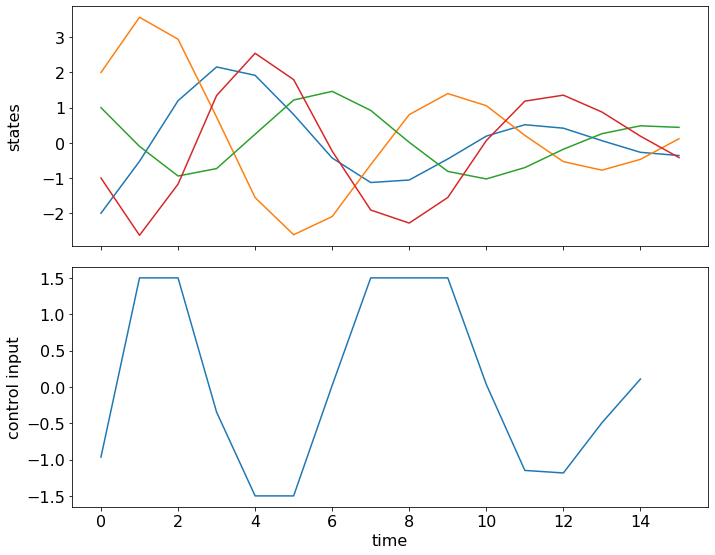

In [40]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(X)
ax[1].plot(U)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()

## Task 07: Create and run MPC main loop
Now that everything is working, we can finally run the MPC loop.
At each iteration:

- fix the initial state by using the optimization variable bounds
- run the solver. Pass at least ``lbx, ubx, lbg, ubg``.
- extract the **current** control input from the optimal solution
- similarly to **Task 03:** Simulate the system (with the obtained control input) and obtain the next state
- store the current state and solution to ``res_x`` and ``res_u``
- reset the initial state to the next state

In [42]:
x_0 = np.array([-2,2,1,-1]).reshape(4,1)
res_x = [x_0]
res_u = []

N_sim = 50

# Write your code here:

for i in range(N_sim):
    ### fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
  
    ### solve optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:]
    res_u.append(u_k)

    ### simulate the system
    x_next = f(x_0,u_k)
    res_x.append(x_next)
    x_0 = x_next
    
# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)
res_u = np.concatenate(res_u, axis=1)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      344
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       75

Total number of variables............................:       75
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       60
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  3.1893720e-02 1.73e-18 5.27e-16  -1.0 1.59e-02    -  1.00e+00 1.00e+00h  1
   2  3.1891612e-02 3.47e-18 2.64e-16  -2.5 1.58e-04    -  1.00e+00 1.00e+00f  1
   3  3.1891612e-02 3.47e-18 2.33e-16  -3.8 6.94e-07    -  1.00e+00 1.00e+00h  1
   4  3.1891612e-02 3.47e-18 5.47e-16  -5.7 1.87e-08    -  1.00e+00 1.00e+00h  1
   5  3.1891612e-02 3.47e-18 2.80e-16  -8.6 2.32e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   3.1891611912757550e-02    3.1891611912757550e-02
Dual infeasibility......:   2.7979261135131013e-16    2.7979261135131013e-16
Constraint violation....:   3.4694469519536142e-18    3.4694469519536142e-18
Complementarity.........:   2.5059038456803381e-09    2.5059038456803381e-09
Overall NLP error.......:   2.5059038456803381e-09    2.5059038456803381e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

### Plot the results

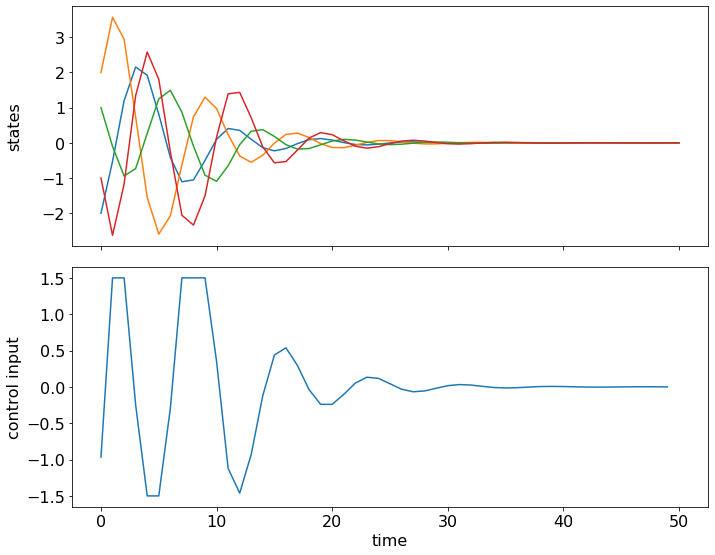

In [29]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x.T)
ax[1].plot(res_u.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()

Congratulations, the system appears to be stable now! Also note that the optimal solution respects your choosen constraints with respect to the control inputs. 

You have now implemented your first MPC scheme!